In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels

In [3]:
from rkhs import compute_shifted_coverage, compute_adaptive_threshold


In [69]:
def generate_cqr_data():
    # number of training examples
    n_train = 2000
    # number of test examples (to evaluate average coverage and length)
    n_test = 1000

    def f(x):
        ''' Construct data (1D example)
        '''
        ax = 0*x
        for i in range(len(x)):
            ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
            ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
        return ax.astype(np.float32)

    # training features
    x_train = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)

    # test features
    x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

    # generate labels
    y_train = f(x_train)
    y_test = f(x_test)

    # reshape the features
    x_train = np.reshape(x_train,(n_train,1))
    x_test = np.reshape(x_test,(n_test,1))
    
    calibration_set_size = 1000
    train_set_size = len(y_train) - calibration_set_size
    x_train_final = x_train[ : train_set_size]
    x_calib = x_train[train_set_size : ]
    y_train_final = y_train[ : train_set_size]
    y_calib = y_train[train_set_size : ]
    
    return x_train_final, y_train_final, x_calib, y_calib, x_test, y_test


In [137]:
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data()

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(4)

reg = LinearRegression().fit(x_train_final, y_train_final)
scores_calib = np.abs(reg.predict(x_calib) - y_calib)
scores_test = np.abs(reg.predict(x_test) - y_test)

In [211]:
alpha = 0.9
selectedRadius = 40
gamma = 0.5
z_calib = None
z_test = None
eps = 0
_, adaptive__marginal_coverage, adaptive_thresholds = compute_shifted_coverage(
        scores_test,
        scores_calib,
        x_calib,
        x_test,
        None,
        kernel="rbf",
        alpha=alpha,
        radius=selectedRadius,
        gamma=gamma,
        z_calib=z_calib,
        z_test=z_test,
        exact=True,
        eps=eps
    )



100%|██████████| 1000/1000 [10:57<00:00,  1.52it/s]


In [212]:
ag_cond_marginal = np.mean(scores_test <= adaptive_thresholds)

from scipy.stats import norm
weights = norm.pdf(x_test, loc=loc_1, scale=scale)
weights /= np.sum(weights)

ag_cond_cov1 = np.sum(weights.flatten() * (scores_test <= adaptive_thresholds))

weights = norm.pdf(x_test, loc=loc_2, scale=scale)
weights /= np.sum(weights)

ag_cond_cov2 = np.sum(weights.flatten() * (scores_test <= adaptive_thresholds))

print(ag_cond_marginal, ag_cond_cov1, ag_cond_cov2)

0.902 0.8686538606044628 0.9486369670237511


In [214]:
prob = setup_full_cvx_dual(x_calib, scores_calib, 'rbf', gamma, alpha, z_calib)
prob.param_dict['radius'].value = np.array([[selectedRadius]])
prob.solve(
                solver='MOSEK', 
                verbose=False, 
                mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.dual}
            )
c0 = prob.constraints[-1].dual_value
weights = prob.var_dict['weights'].value
K = pairwise_kernels(
    X = x_calib,
    metric='rbf',
    gamma=gamma
)

min_ind = np.argsort(np.abs(x_calib.flatten() - loc_1).flatten())[0]
tilt = np.zeros((x_calib.shape[0], 1))
tilt[min_ind] = 1

cov_gap_1 = alpha-(1/selectedRadius) * tilt.T @ K @ weights / np.mean(K @ tilt)
print(cov_gap_1)

min_ind = np.argsort(np.abs(x_calib.flatten() - loc_2).flatten())[0]
tilt = np.zeros((x_calib.shape[0], 1))
tilt[min_ind] = 1

cov_gap_2 = alpha-(1/selectedRadius) * tilt.T @ K @ weights / np.mean(K @ tilt)
print(cov_gap_2)


[0.88565155]
[0.91491923]


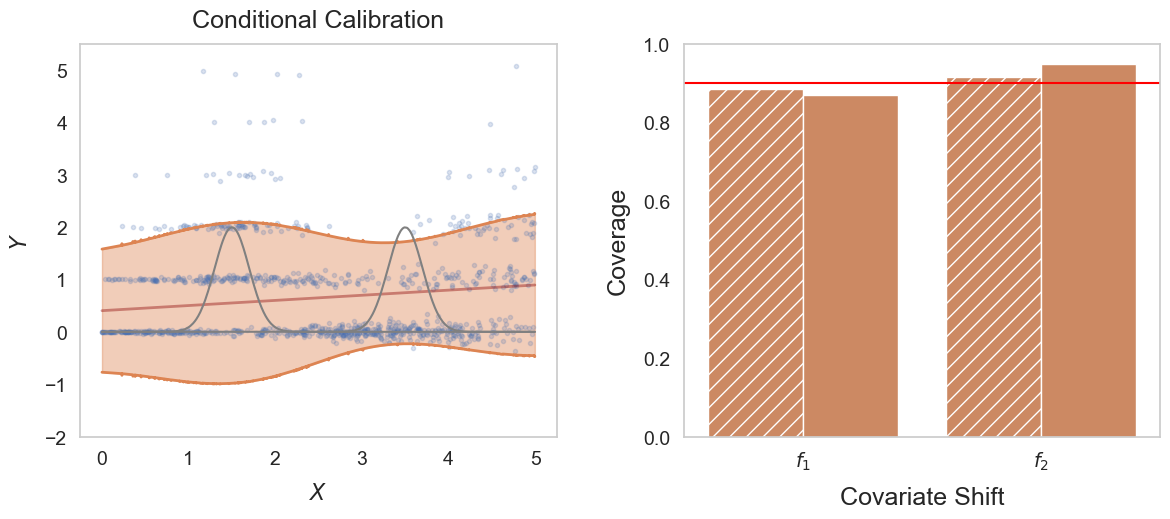

In [215]:
#fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(12.5, 6)

sorted_idx = np.argsort(x_test.flatten())

test_predictions = reg.predict(x_test[sorted_idx])
adaptiveThresholds = adaptive_thresholds[sorted_idx]

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_test[sorted_idx], y_test[sorted_idx], '.', alpha=0.2)
ax1.plot(x_test[sorted_idx], test_predictions, color='darkred', alpha=0.4, lw=2)
ax1.plot(x_test[sorted_idx], test_predictions + adaptiveThresholds, color=cp[1], lw=2)
ax1.plot(x_test[sorted_idx], test_predictions - adaptiveThresholds, color=cp[1], lw=2)
ax1.fill_between(x_test[sorted_idx].flatten(), test_predictions + adaptiveThresholds, 
                 test_predictions - adaptiveThresholds, 
                 color=cp[1], alpha=0.4, label='split prediction interval')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Conditional Calibration", fontsize=18, pad=12)
ax1.set_ylim(-2,5.5)

ax1.plot(x_test[sorted_idx], norm.pdf(x_test[sorted_idx], loc=loc_1, scale=scale), color='grey')
ax1.plot(x_test[sorted_idx], norm.pdf(x_test[sorted_idx], loc=loc_2, scale=scale), color='grey')

coverageData = pd.DataFrame({'Method': ['Split','Conditional'], 'Covariate Shift' : ['$f_1$','$f_1$'], 
                            'Coverage': [cov_gap_1[0],
                                         ag_cond_cov1]})
coverageData = pd.concat([coverageData,
                        pd.DataFrame({'Method': ['Split','Conditional'], 'Covariate Shift' : ['$f_2$', '$f_2$'], 
                            'Coverage': [cov_gap_2[0],
                                         ag_cond_cov2]})
                         ], axis = 0)

ax3 = fig.add_subplot(1, 2, 2)

f = sns.barplot(
    coverageData, 
    x='Covariate Shift', 
    y='Coverage',
    hue='Method',
    palette=cp,
    ax = ax3
)
orange = f.patches[2].get_facecolor()
f.patches[0].set_hatch('//')
f.patches[0].set_facecolor(orange)
f.patches[1].set_hatch('//')
f.patches[1].set_facecolor(orange)

plt.draw()
f.axhline(0.9, color='red')
f.legend_.remove()
# plt.legend(fontsize=18)
ax3.set_ylabel("Coverage", fontsize=18, labelpad=10)
ax3.set_xlabel("Covariate Shift", fontsize=18, labelpad=10)
ax3.set_ylim(0.,1)
ax3.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout(pad=3)

# plt.savefig('cqrAgnostic.pdf')


In [186]:
hatches

['//', '', '//', '']

In [133]:

loc_1 = 1.5
loc_2 = 3.5
scale = 0.2

In [76]:
print(np.mean(scores_test < adaptive_thresholds))

from scipy.stats import norm
weights = norm.pdf(x_test, loc=loc_1, scale=scale)
weights /= np.sum(weights)

print(np.sum(weights.flatten() * (scores_test < adaptive_thresholds)))

weights = norm.pdf(x_test, loc=loc_2, scale=scale)
weights /= np.sum(weights)

print(np.sum(weights.flatten() * (scores_test < adaptive_thresholds)))

0.91
0.842206726906269
0.9530765076788075


In [125]:
import math
np.mean(scores_test <= np.quantile(scores_calib, [math.ceil(0.9 * (len(scores_calib) + 1)) / len(scores_calib)]))



0.894

In [138]:
# fixed weights

split_threshold = np.quantile(scores_calib, [math.ceil(0.9 * (len(scores_calib) + 1)) / len(scores_calib)])

split_marginal = np.mean(scores_test <= split_threshold)

from scipy.stats import norm
weights = norm.pdf(x_test, loc=loc_1, scale=scale)
weights /= np.sum(weights)

split_cov1 = np.sum(weights.flatten() * (scores_test <= split_threshold))

weights = norm.pdf(x_test, loc=loc_2, scale=scale)
weights /= np.sum(weights)

split_cov2 = np.sum(weights.flatten() * (scores_test <= split_threshold))
print(split_marginal, split_cov1, split_cov2)


z_0 = np.ones((x_calib.shape[0], 1))
z_1 = norm.pdf(x_calib, loc=loc_1, scale=scale)
z_2 = norm.pdf(x_calib, loc=loc_2, scale=scale)
z_calib = np.concatenate((z_0, z_1, z_2), axis=1)


z_0 = np.ones((x_test.shape[0], 1))
z_1 = norm.pdf(x_test, loc=loc_1, scale=scale)
z_2 = norm.pdf(x_test, loc=loc_2, scale=scale)
z_test = np.concatenate((z_0, z_1, z_2), axis=1)

_, adaptive__marginal_coverage, adaptive_thresholds = compute_shifted_coverage(
        scores_test,
        scores_calib,
        x_calib,
        x_test,
        None,
        kernel=None,
        alpha=alpha,
        radius=None,
        gamma=None,
        z_calib=z_calib,
        z_test=z_test,
        exact=True,
        eps=eps
    )

cond_marginal = np.mean(scores_test <= adaptive_thresholds)

from scipy.stats import norm
weights = norm.pdf(x_test, loc=loc_1, scale=scale)
weights /= np.sum(weights)

cond_cov1 = np.sum(weights.flatten() * (scores_test <= adaptive_thresholds))

weights = norm.pdf(x_test, loc=loc_2, scale=scale)
weights /= np.sum(weights)

cond_cov2 = np.sum(weights.flatten() * (scores_test <= adaptive_thresholds))

print(cond_marginal, cond_cov1, cond_cov2)

0.907 0.7411363174427281 0.9790158355345027


100%|██████████| 1000/1000 [00:20<00:00, 49.35it/s]

0.907 0.9138907410613107 0.9056194764438695


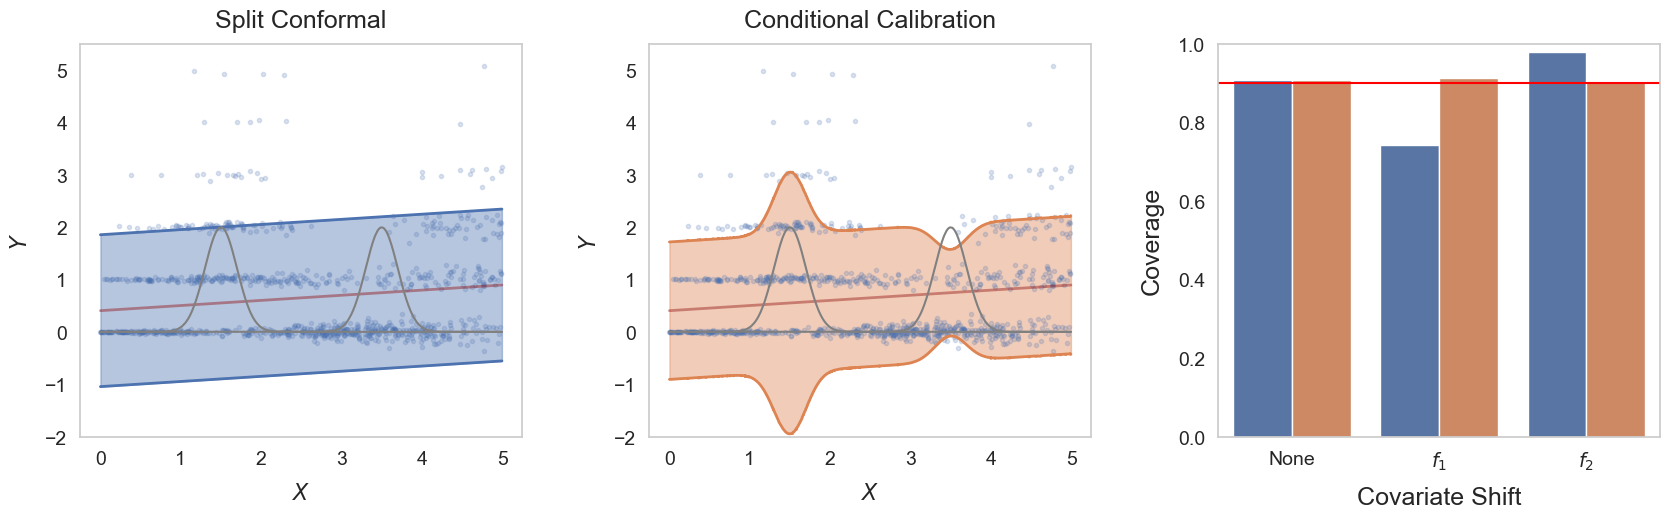

In [140]:
#fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(17.5, 6)

sorted_idx = np.argsort(x_test.flatten())

test_predictions = reg.predict(x_test[sorted_idx])

q = split_threshold
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x_test[sorted_idx], y_test[sorted_idx], '.', alpha=0.2)
ax1.plot(x_test[sorted_idx], test_predictions, lw=2, color='darkred', alpha=0.4)
ax1.plot(x_test[sorted_idx], test_predictions + q, color=cp[0], lw=2)
ax1.plot(x_test[sorted_idx], test_predictions - q, color=cp[0], lw=2)
ax1.fill_between(x_test[sorted_idx].flatten(), test_predictions - q, test_predictions + q, 
                 color=cp[0], alpha=0.4, label='split prediction interval')
ax1.set_ylim(-2,5.5)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Split Conformal", fontsize=18, pad=12)

ax1.plot(x_test[sorted_idx], norm.pdf(x_test[sorted_idx], loc=loc_1, scale=scale), color='grey')
ax1.plot(x_test[sorted_idx], norm.pdf(x_test[sorted_idx], loc=loc_2, scale=scale), color='grey')

adaptiveThresholds = adaptive_thresholds[sorted_idx]

ax2 = fig.add_subplot(1, 3, 2, sharex = ax1, sharey = ax1)
ax2.plot(x_test[sorted_idx], y_test[sorted_idx], '.', alpha=0.2)
ax2.plot(x_test[sorted_idx], test_predictions, color='darkred', alpha=0.4, lw=2)
ax2.plot(x_test[sorted_idx], test_predictions + adaptiveThresholds, color=cp[1], lw=2)
ax2.plot(x_test[sorted_idx], test_predictions - adaptiveThresholds, color=cp[1], lw=2)

ax2.fill_between(x_test[sorted_idx].flatten(), test_predictions + adaptiveThresholds, 
                 test_predictions - adaptiveThresholds, 
                 color=cp[1], alpha=0.4, label='split prediction interval')
ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)

ax2.plot(x_test[sorted_idx], norm.pdf(x_test[sorted_idx], loc=loc_1, scale=scale), color='grey')
ax2.plot(x_test[sorted_idx], norm.pdf(x_test[sorted_idx], loc=loc_2, scale=scale), color='grey')

coverageData = pd.DataFrame({'Method': ['Split','Conditional'], 'Covariate Shift' : ['None','None'], 
                            'Coverage': [split_marginal,
                                         cond_marginal]})
coverageData = pd.concat([coverageData,
                        pd.DataFrame({'Method': ['Split','Conditional'], 'Covariate Shift' : ['$f_1$', '$f_1$'], 
                            'Coverage': [split_cov1,
                                         cond_cov1]})
                         ], axis = 0)
coverageData = pd.concat([coverageData,
                        pd.DataFrame({'Method': ['Split','Conditional'], 'Covariate Shift' : ['$f_2$', '$f_2$'], 
                            'Coverage': [split_cov2,
                                         cond_cov2]})
                         ], axis = 0)

ax3 = fig.add_subplot(1, 3, 3)
f = sns.barplot(
    coverageData, 
    x='Covariate Shift', 
    y='Coverage',
    hue='Method',
    palette=cp,
    ax = ax3
)
f.axhline(0.9, color='red')
f.legend_.remove()
# plt.legend(fontsize=18)
ax3.set_ylabel("Coverage", fontsize=18, labelpad=10)
ax3.set_xlabel("Covariate Shift", fontsize=18, labelpad=10)
ax3.set_ylim(0.,1)
ax3.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout(pad=3)

plt.savefig('cqrShiftComparison_auto.pdf')


[0.89131133] [0.90626607]


In [6]:
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data()

reg = LinearRegression().fit(x_train_final, y_train_final)
scores_calib = np.abs(reg.predict(x_calib) - y_calib)
scores_test = np.abs(reg.predict(x_test) - y_test)

def run_synthetic_trial(reg, alpha, radius, gamma, n_test, shift_loc):
    _, _, x_calib, y_calib, x_test, y_test = generate_cqr_data()

    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    scores_test = np.abs(reg.predict(x_test) - y_test)
        
    est_coverage, weighted_coverage, thresholds = compute_shifted_coverage(
        scores_test[0:n_test],
        scores_calib,
        x_calib,
        x_test[0:n_test,],
        shift_loc,
        kernel="rbf",
        alpha=alpha,
        radius=radius,
        gamma=gamma
    )
    
    return est_coverage, weighted_coverage

n_trials = 10
alpha = 0.9
radius = 1
n_test = 100
gamma = 2
shift_locs = [3.5, 4.5] #[0.5, 1.4, 2.5, 3.5, 4.5]

df = pd.DataFrame()

for shift_loc in shift_locs:
    est_coverages = []
    emp_coverages = []
    for i in range(n_trials):
        try:
            est_cov, emp_cov = run_synthetic_trial(reg, alpha, radius, gamma, n_test, shift_loc)
            est_coverages.append(est_cov)
            emp_coverages.append(emp_cov)
            print(f"Trial {i}: {est_cov}, {emp_cov}")
        except SolverError:
            continue
    a_df = pd.DataFrame({'empirical coverage' : emp_coverages, 'estimated coverage': est_coverages})
    a_df['shift_loc'] = shift_loc
    df = pd.concat([df, a_df], axis=0)
    

100%|█████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


Trial 0: 0.9456800691719593, 0.9620845434064964


100%|█████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Trial 1: 0.9483124312240642, 0.9622465128625827


100%|█████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Trial 2: 0.9360883225794476, 0.8942345282101078


100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Trial 3: 0.9372616962011079, 0.9302727464315248


100%|█████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Trial 4: 0.9525388932044103, 0.9582241012799396


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.08it/s]


Trial 5: 0.940986416324877, 0.975183084540417


100%|█████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Trial 6: 0.9460548568952443, 0.9873159200909768


100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Trial 7: 0.9466914980947585, 0.9559941122700362


100%|█████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Trial 8: 0.9546358346346328, 0.9612283555900746


100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Trial 9: 0.9576935589857054, 0.9772028277069883


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


Trial 0: 0.8368169253710371, 0.7724189224621459


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Trial 1: 0.826072272892606, 0.8281717339610204


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


Trial 2: 0.8041503434265012, 0.6940187719253221


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


Trial 3: 0.80657954782144, 0.7840112479095961


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


Trial 4: 0.8104967825350118, 0.9247198307530882


100%|█████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Trial 5: 0.8592166272107574, 0.8331123042812705


100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


Trial 6: 0.8035192061669433, 0.8751381685534336


100%|█████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Trial 7: 0.8342255210554183, 0.965185065995384


100%|█████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


Trial 8: 0.828067068045719, 0.9104931901630164


100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]

Trial 9: 0.8264373277766368, 0.8855805576138608


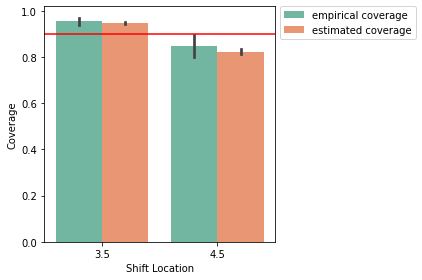

In [9]:
import seaborn as sns
import pandas as pd

melted_df = pd.melt(df, id_vars=['shift_loc'], value_vars=['empirical coverage', 'estimated coverage'])
melted_df = melted_df.rename(columns={"shift_loc": "Shift Location", "value": "Coverage"})

fig = sns.barplot(
    melted_df, 
    x='Shift Location', 
    y='Coverage',
    hue='variable',
    palette=sns.color_palette("Set2")
)
fig.axhline(alpha, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

fig.get_figure().savefig('synthetic_rkhs_coverage.png')


100%|███████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]

0.8998966949157221 0.8391796279611702


(-2.0, 6.0)

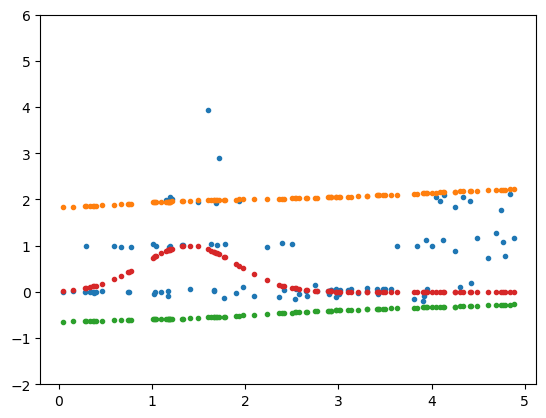

In [195]:
alpha = 0.9
radius = 1000**2
n_test = 200
gamma = 2

n_test = 100

idx = np.argmin(np.abs(x_calib - 1.4))
g_weights = np.zeros((len(x_calib) + 1,))
g_weights[idx] = 1

K_fhat = rbf_kernel(
    X=x_test[0:n_test,:],
    Y=np.concatenate([x_calib, x_test[0,:].reshape(1,-1)], axis=0),
    gamma=gamma
)
    
est_coverage, weighted_coverage, thresholds = compute_shifted_coverage(
    scores_test,
    scores_calib,
    x_calib,
    x_test[0:n_test,:],
    g_weights,
    kernel="rbf",
    alpha=alpha,
    radius=radius,
    gamma=gamma
)
print(est_coverage, weighted_coverage)


plt.figure()
plt.plot(x_test[0:n_test], y_test[0:n_test], '.')
plt.plot(x_test[0:n_test], reg.predict(x_test[0:n_test]) + thresholds, '.', label='upper')
plt.plot(x_test[0:n_test], reg.predict(x_test[0:n_test]) - thresholds, '.', label='lower')
plt.plot(x_test[0:n_test], K_fhat @ g_weights, '.', label='shift')
plt.ylim(-2, 6)


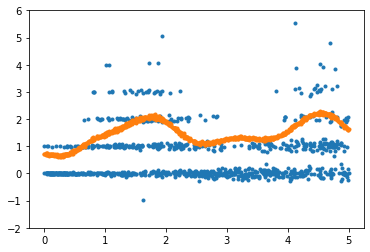

In [18]:
#from rkhs import setup_cvx_primal, setup_cvx_dual
from rkhs import setup_cvx_dual
alpha = 0.9
radius = 200*1000**2
gamma = 0.5

#prob_1 = setup_cvx_problem(
#    x_calib,
#    scores_calib,
#    kernel="rbf",
#    gamma=gamma,
#    alpha=alpha,
#    radius=radius
#)

K = rbf_kernel(
    X=np.concatenate([x_calib, x_test[0,:].reshape(1,-1)], axis=0),
    gamma=gamma
)

prob_2 = setup_cvx_dual(
    x_calib,
    scores_calib,
    kernel="rbf",
    gamma=gamma,
    alpha=alpha,
)
f_hat = compute_adaptive_threshold(
    prob_2,
    scores_calib,
    x_calib,
    x_test[0,:],
    kernel="rbf",
    gamma=gamma,
    radius = radius
)

thresholds = f_hat['c0'] + K @ f_hat['weights']

x_plot = np.concatenate([x_calib, x_test[0,:].reshape(1,-1)], axis=0)
plt.plot(x_calib, y_calib, '.')
plt.plot(x_plot, reg.predict(x_plot) + thresholds, '.')
#plt.plot(x_plot, reg.predict(x_plot) - thresholds, '.')
plt.ylim(-2, 6)
plt.savefig('cqrData.png')

In [17]:
plt.savefig('cqrData.png')

<Figure size 432x288 with 0 Axes>